# Transfer Learning for Jet Tagging in Particle Physics: GNN

This is the second accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

### Stage 2: Transfer Learning via GNN

The current state-of-the-art jet tagging model uses a Graph Neural Network architecture. Our second goal is then to build a Teacher and a Student GNN and implement transfer learning similarly to what we did with the FCCN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import time
from preprocess import *
from helper import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

Similarly to the first notebook, we will start by loading in the data and preprocessing. Note that since we are now working with *graphs*, the preprocessing steps will differ significantly!

In [2]:
cons_data, cons_labels, cons_weights, cons_features = get_data("./data/test.h5", attribute="constituents")

print("---------- Constituent-level data ----------------", "\n")
print("Data shape [input_size, num_features, num_constituents]:", cons_data.shape, "\n")
print("Feature names:", cons_features)
print("Feature names (human-readable):", [human_feature(f) for f in cons_features])

---------- Constituent-level data ---------------- 

Data shape [input_size, num_features, num_constituents]: (2484117, 4, 200) 

Feature names: ['fjet_clus_E' 'fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_pt']
Feature names (human-readable): ['constituent energy', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent transverse momentum']


To implement our GNN, we then need to form graphs using our data. We will do so using the k-nearest-neighbors algorithm, and we will try to run on GPU to accelerate the graph making process.

In [3]:
from preprocess import prepare_graphs

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print("Device:", device)

graphs = prepare_graphs(cons_data, cons_labels, k=16, weights=cons_weights, device=device, batch_size=1024)

Device: cuda


100%|█████████████████████████████████████| 2426/2426 [2:57:34<00:00,  4.39s/it]


#### Visualize

We can visualize the graphs we just created!

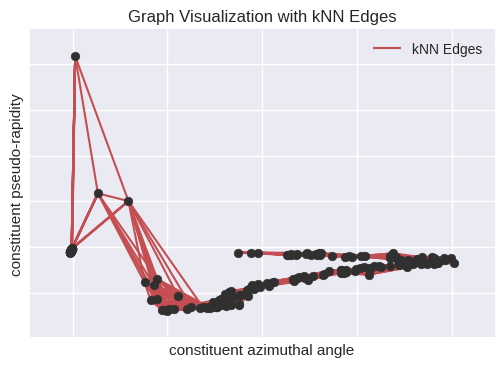

In [4]:
from visualize import visualize_graph

visualize_graph(graphs[100], x_axis='fjet_clus_phi', y_axis='fjet_clus_eta')

#### Build the Teacher GNN

Let's build the Teacher GNN and train it on the high-resolution data:

In [ ]:
from model import TeacherGNN
from preprocess import split_graphs
from model import train_one_epoch_gnn, test_gnn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:",device)

# prepare data
train_dataset, val_dataset, test_dataset = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=384, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=384, shuffle=True)

# initialize model
teacher_gnn = TeacherGNN().to(device)
optimizer = optim.AdamW(teacher_gnn.parameters(), lr=3e-4, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
t0 = time.time()
num_epochs = 30
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch_gnn(teacher_gnn, device, train_loader, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test_gnn(teacher_gnn, device, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    if e%5 == 0:
        print(f"E {e:02d} -- Train loss: {loss:.4f} -- Train acc: {acc:.4f} -- "\
                + f"Val loss: {val_loss:.4f} -- Val acc: {val_acc:.4f} -- "\
              + f"t elapsed: {time_elapsed(t0, time.time())} min"
    )

Device: cuda
E 05 -- Train loss: 0.6931 -- Train acc: 0.5001 -- Val loss: 0.6936 -- Val acc: 0.5016 -- t elapsed: 174.52 min


In [ ]:
from visualize import plot_loss_and_accuracy

plot_loss_and_accuracy(loss_list, val_loss_list, acc_list, val_acc_list)

In [ ]:
from visualize import plot_confusion_matrices

true = []
pred = []
for d in test_dataset:
    l = d.y.item()
    true.append(int(l))
    p = np.argmax(teacher_gnn(d.to(device)).cpu().detach().numpy())
    pred.append(p)

plot_confusion_matrices(true, pred, "Teacher GNN")